**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/binary-classification).**

---


# Introduction #

* You will use your new knowledge to train a model on binary classification.
* Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex6 import *

# Preparation

In [2]:
# Import packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [3]:
# Import data
hotel = pd.read_csv('../input/dl-course-data/hotel.csv')

# Separate target from predictors
X = hotel.copy()
y = X.pop('is_canceled')

# Encode months
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

# Separate numerical from categorical data
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

# Preprocess data
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)
preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# Stratify (make sure classes are evenlly represented across splits)
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

# Separate training from validation data
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

# Define input shape
input_shape = [X_train.shape[1]]

# Build Model

<figure style="padding: 1em;">
<img src="https://i.imgur.com/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"></figcaption>
</figure>

In [4]:
# Import packages
from tensorflow import keras
from tensorflow.keras import layers

# Define model (given in diagram)
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

2022-04-04 14:37:38.181948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 14:37:38.270615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 14:37:38.271304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 14:37:38.272353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
# Define optimizer, loss, and metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

2022-04-04 14:37:40.705422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
175/175 [==============================] - 3s 7ms/step - loss: 0.4823 - binary_accuracy: 0.7720 - val_loss: 0.4319 - val_binary_accuracy: 0.8103
Epoch 2/200
175/175 [==============================] - 1s 6ms/step - loss: 0.4222 - binary_accuracy: 0.8026 - val_loss: 0.4004 - val_binary_accuracy: 0.8153
Epoch 3/200
175/175 [==============================] - 1s 5ms/step - loss: 0.4102 - binary_accuracy: 0.8069 - val_loss: 0.3959 - val_binary_accuracy: 0.8178
Epoch 4/200
175/175 [==============================] - 1s 5ms/step - loss: 0.4015 - binary_accuracy: 0.8116 - val_loss: 0.3885 - val_binary_accuracy: 0.8215
Epoch 5/200
175/175 [==============================] - 1s 4ms/step - loss: 0.3977 - binary_accuracy: 0.8136 - val_loss: 0.3852 - val_binary_accuracy: 0.8242
Epoch 6/200
175/175 [==============================] - 1s 4ms/step - loss: 0.3922 - binary_accuracy: 0.8170 - val_loss: 0.3818 - val_binary_accuracy: 0.8231
Epoch 7/200
175/175 [==============================] - 1s 

<AxesSubplot:title={'center':'Accuracy'}>

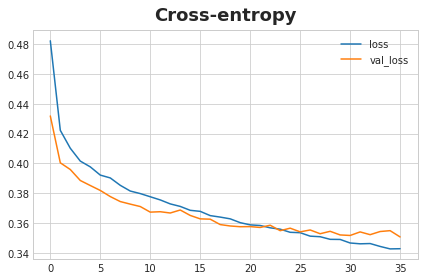

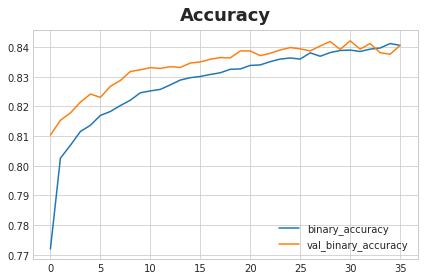

In [6]:
# Define early stopping behaviour
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

# Plot results
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*